In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown

# Load the datasets

In [2]:
gdown.download(
    'https://drive.google.com/uc?id=1pkPyS9TFXxtW23KPhIv5Kj3WKIjwNgZL',
    '10xpbmc10k-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1pkPyS9TFXxtW23KPhIv5Kj3WKIjwNgZL
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/10xpbmc10k-expressions.h5ad
68.6MB [00:00, 93.0MB/s]


'10xpbmc10k-expressions.h5ad'

In [3]:
scrna = sc.read('10xpbmc10k-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc',
    '10xpbmc10k-peaks.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/10xpbmc10k-peaks.h5ad
789MB [00:15, 52.4MB/s] 


'10xpbmc10k-peaks.h5ad'

In [5]:
scatac = sc.read('10xpbmc10k-peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

# Configure and train the model

In [7]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'relu'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [8]:
model.train(
    n_iters=10000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=1000,
    verbose=1
)

 |████████████████████| 100.0% iter=10000/10000, time=18.29(s), loss=0.4424, recon=0.4420, kl=37.2291, integ=0.0000, cycle=0.0000, val_loss=0.4422, val_recon=0.4418, val_kl=35.6367, val_integ=0.0000, val_cycle=0.0000

### Plot training history

In [9]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,0.474460,0.474429,16.108519,0.0,0.0,0.452072,0.452011,21.318684,0,0
1,2000,0.450354,0.450203,32.298426,0.0,0.0,0.446983,0.446784,34.781399,0,0
2,3000,0.448909,0.448629,37.786131,0.0,0.0,0.445594,0.445287,35.716545,0,0
3,4000,0.443000,0.442643,36.559454,0.0,0.0,0.444489,0.444150,33.889698,0,0
4,5000,0.443819,0.443459,36.019892,0.0,0.0,0.443693,0.443347,34.634445,0,0
5,6000,0.444594,0.444233,36.109872,0.0,0.0,0.443085,0.442735,34.953503,0,0
6,7000,0.442992,0.442626,36.571019,0.0,0.0,0.442878,0.442529,34.883209,0,0
7,8000,0.442809,0.442443,36.612384,0.0,0.0,0.442589,0.442237,35.187195,0,0
8,9000,0.443805,0.443435,36.919107,0.0,0.0,0.442369,0.442012,35.723331,0,0
9,9999,0.442369,0.441996,37.229089,0.0,0.0,0.442189,0.441832,35.636658,0,0


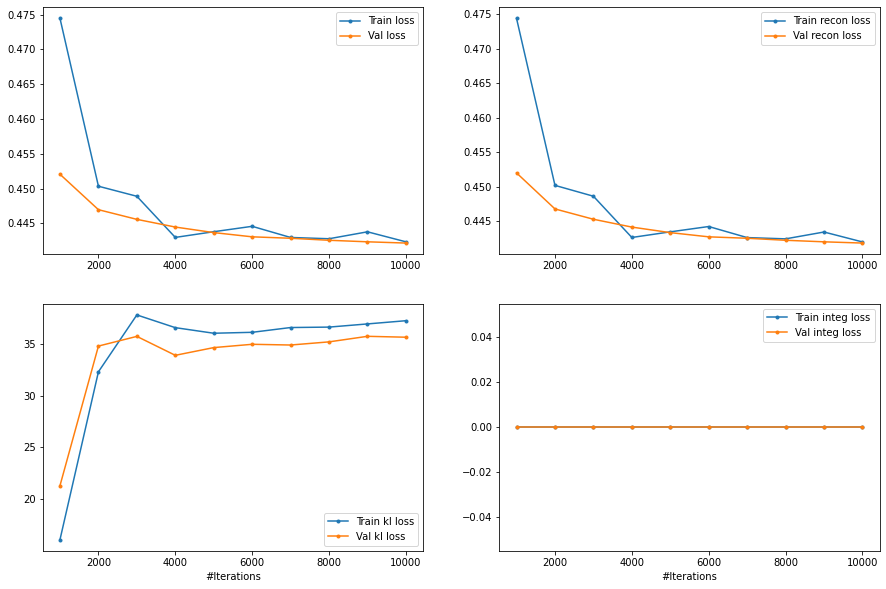

In [10]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

## UMAP plot of the latent space

In [12]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    batch_size=256,
    layers=[['count'], [None]]
)
z

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [13]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


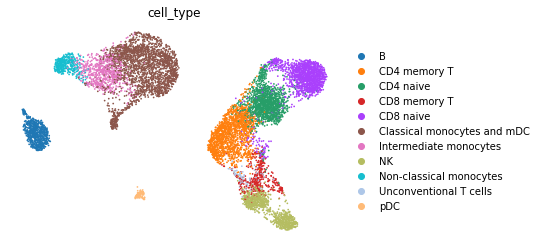

In [14]:
sc.pl.umap(z, color='cell_type', ncols=1, frameon=False)

In [15]:
z.write('../data/integrated/multigrate/10xpbmc10k-multigrate.h5ad')

# Remove unnecessary files

In [16]:
!rm '10xpbmc10k-peaks.h5ad'
!rm '10xpbmc10k-expressions.h5ad'